In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.simplefilter(action="ignore")

from statsmodels.stats.weightstats import ttest_ind
from scipy import stats
from sklearn import metrics

%matplotlib inline

## Load and Check Primary Dataset 
---

In [2]:
df = pd.read_stata("maindataset_thesis.dta")
df = df.query('tk01 != 5 and tk01 != 7') # exclude the retired
df.sample(5)

,sex,respondent,age,marstat,pidlink,ar02b,hhid07,pid07,hhid00,pid00,...,E_hr1type_t1,F_hr1type_t1,IHK_t1,IHK,nmkab2014,hhid14,pid14,_2014,married,single
2198,1,3,22.0,single,160050008,13,1600500,8.0,1600511,3.0,...,2.14,1531571.26,43.50,79.37,CILACAP,,NaN,0,0,1
5627,1,3,24.0,single,065150007,3,0651500,7.0,,NaN,...,12000001.00,2000001.00,72.13,116.78,BANDAR LAMPUNG,0651500,7.0,1,0,1
8048,1,3,15.0,single,240303105,3,2403031,5.0,,NaN,...,55600001.00,5500001.00,79.57,118.99,JOMBANG,2403031,5.0,1,0,1
6361,0,3,17.0,single,123120005,3,1231200,5.0,,NaN,...,7000001.00,2000001.00,76.20,117.13,CIREBON,1231200,5.0,1,0,1
3636,1,3,16.0,single,272010003,3,2720100,3.0,2720100,3.0,...,1.00,1500001.00,44.42,77.80,KARANG ASEM,,NaN,0,0,1


In [3]:
df.shape

(9348, 48)

In [4]:
df.columns

Index(['sex', 'respondent', 'age', 'marstat', 'pidlink', 'ar02b', 'hhid07',
       'pid07', 'hhid00', 'pid00', 'tk02', 'tk03', 'tk04', 'tk01a', 'tk01b',
       'tk01c', 'tk01d', 'tk16d', 'tk16i', 'tk01', 'tk25a9x', 'tk16h', 'main',
       'NEET', 'NEET__just_other_', 'year', 'nonfood_t1', 'food_t1', 'pce_t1',
       'kabid_t1', 'nonfood_t', 'food_t', 'pce_t', 'kabid', 'A_hr1type_t',
       'E_hr1type_t', 'F_hr1type_t', 'A_hr1type_t1', 'E_hr1type_t1',
       'F_hr1type_t1', 'IHK_t1', 'IHK', 'nmkab2014', 'hhid14', 'pid14',
       '_2014', 'married', 'single'],
      dtype='object')

In [5]:
df["tk01"].value_counts()

3     3963
1     3197
4     1217
95     544
2      427
Name: tk01, dtype: int64

In [6]:
a = df.query('tk01 == 4 & NEET == 1')
b = df.query('tk01 == 95 & NEET == 1')
c = df.query('tk01 == 2 & NEET == 1')
d = df.query('tk01 == 1 & NEET == 0')
e = df.query('tk01 == 3 & NEET == 0')

In [7]:
df1 = pd.concat([a,b,c,d,e])
z = df1.index.tolist()

In [8]:
#make sure that main activity in line with our NEET definition
w = []
for i in df.index.tolist():
    if i not in z: # check wheter the main activity should be NEET but they have more than one activity which non-NEET
        w.append(i)

In [9]:
df2 = df.loc[w]
df2["tk01"] = df2[["tk01a", "tk02", "tk03", "tk04"]].sum(axis=1).apply(lambda x: 3 if x == 0 else 1) # "tk01b", "tk01c", "tk01d", "tk25a9x"

# I can't control the mutually exclusiveness within this group
print ("There are", len(df2), "samples based on main activity ALONE should classify to NEET yet actually not--based on series of activity") 

There are 561 samples based on main activity ALONE should classify to NEET yet actually not--based on series of activity


In [10]:
data = pd.concat([df1, df2])
data.sample(5)

,sex,respondent,age,marstat,pidlink,ar02b,hhid07,pid07,hhid00,pid00,...,E_hr1type_t1,F_hr1type_t1,IHK_t1,IHK,nmkab2014,hhid14,pid14,_2014,married,single
3628,1,3,22.0,married,271150009,3,2711531,4.0,2711531,4.0,...,1.0,200001.0,44.42,77.80,KARANG ASEM,,NaN,0,1,0
3539,1,3,20.0,single,264100006,3,2641000,6.0,2641000,6.0,...,1.0,3500001.0,44.42,77.80,DENPASAR,,NaN,0,0,1
8465,1,3,17.0,single,272260008,3,2722600,8.0,,NaN,...,3.0,3.0,77.80,116.27,KARANG ASEM,2722600,8.0,1,0,1
3671,1,3,15.0,single,274080008,3,2740800,8.0,2740800,8.0,...,3.0,4500001.0,44.42,77.80,BULELENG,,NaN,0,0,1
8193,0,3,17.0,married,251280008,3,2512800,8.0,,NaN,...,3.0,700001.0,79.08,117.73,BANGKALAN,2512800,8.0,1,1,0


## Gathering other control variables
---

### 2007

In [11]:
path07 = "C:/Users/Redata/Downloads/read/kemiskinan/hh2007/"
a = pd.read_stata(path07 + "pce07nom.dta")[["hhid07", "hhsize"]]
b = pd.read_stata(path07 + "bk_sc.dta")[["hhid07", "sc05", "sc21x"]]
c = pd.merge(a,b, left_on="hhid07", right_on="hhid07")
e = pd.merge(data[data["year"] == 2007], c, left_on="hhid07", right_on="hhid07", how="left")

In [12]:
sw = pd.read_stata(path07 +"b3a_sw.dta")[["pidlink", "sw01", "sw03b"]]
kk = pd.read_stata(path07 +"b3b_kk1.dta")[["pidlink", "kk01", "kk02a", "kk02c"]]

#education vairables
educ1 = pd.read_stata(path07 +"b3a_dl2.dta")[["dl2type", "pidlink", "dl16j", "dl16ja"]]
educ1_t = pd.merge(educ1.groupby(["pidlink"], as_index=False)["dl2type"].max(), 
         educ1, left_on=["pidlink", "dl2type"], right_on=["pidlink", "dl2type"])

educ2 = pd.read_stata(path07 +"b3a_dl1.dta")[["pidlink", "dl06", "dl07", "dl05b"]]

educ = pd.merge(educ1_t, educ2, left_on="pidlink", right_on="pidlink")

#the distance (in minutes) to school
#convert to minutes
educ.dl16ja = educ.dl16ja.apply(lambda x:60 if x == 2 else x) #change the a hour measurment
educ["dl16j"] = educ["dl16j"] * educ["dl16ja"]

In [13]:
df = sw.copy()
for i in [kk, educ]:
    df = pd.merge(df, i, left_on="pidlink", right_on="pidlink")

In [14]:
def educagg(data):
    one = [2, 11, 90, 72] #primary school
    two = [3, 4, 12, 73] #junior high school
    three = [5, 6, 15, 74] #high school
    four = [60, 61, 62, 63, 13] #college
    if data in one:
        return 1
    elif data in two:
        return 2
    elif data in three:
        return 3
    elif data in four:
        return 4
    else:
        return np.nan
    
df["educ"] = df["dl06"].apply(lambda x: educagg(x)) #aggregation
df["educ"] = df["educ"].fillna(df["dl2type"]) #fillna with another variable

In [15]:
data2007 = pd.merge(e, df, left_on="pidlink", right_on="pidlink", how="left")

### 2014

In [16]:
path14 = "C:/Users/Redata/Downloads/read/kemiskinan/hh2014/"
r = pd.read_stata(path14 + "pce14nom.dta")[["hhid14", "hhsize"]]
s = pd.read_stata(path14 + "bk_sc1.dta")[["hhid14", "sc05", "sc21x"]]
t = pd.merge(r,s, left_on="hhid14", right_on="hhid14")
u = pd.merge(data[data["year"] == 2014], t, left_on="hhid14", right_on="hhid14", how="left")

In [17]:
sw = pd.read_stata(path14 +"b3a_sw.dta")[["pidlink", "sw01", "sw03b"]]
kk = pd.read_stata(path14 +"b3b_kk1.dta")[["pidlink", "kk01", "kk02a", "kk02c"]]


#education vairables
educ1 = pd.read_stata(path14 +"b3a_dl2.dta")[["dl2type", "pidlink", "dl16j", "dl16ja"]]
educ1_t = pd.merge(educ1.groupby(["pidlink"], as_index=False)["dl2type"].max(), 
         educ1, left_on=["pidlink", "dl2type"], right_on=["pidlink", "dl2type"])

educ2 = pd.read_stata(path14 +"b3a_dl1.dta")[["pidlink", "dl06", "dl07", "dl05b"]]

educ = pd.merge(educ1_t, educ2, left_on="pidlink", right_on="pidlink")

#the distance (in minutes) to school
#convert to minutes
educ.dl16ja = educ.dl16ja.astype("str").str.extract(r'(\d+)')[0].apply(lambda x: 0 if x != "1" else 1).astype("float")
educ.dl16ja = educ.dl16ja.apply(lambda x:60 if x == 2 else x) #change the a hour measurment
educ["dl16j"] = educ["dl16j"].astype("float") * educ["dl16ja"]

In [18]:
df = sw.copy()
for i in [kk, educ]:
    df = pd.merge(df, i, left_on="pidlink", right_on="pidlink")

In [19]:
df["educ"] = df["dl06"].apply(lambda x: educagg(x)) #aggregation
df["educ"] = df["educ"].fillna(df["dl2type"]) #fillna with another variable

In [20]:
data2014 = pd.merge(u, df, left_on="pidlink", right_on="pidlink", how="left")

## Concat both year

In [21]:
data = pd.concat([data2007, data2014])
data["sc05"] = data["sc05"].astype("str").str.extract(r'(\d+)')[0].apply(lambda x: 0 if x != "1" else 1).astype("int")


data.sample(10)

,sex,respondent,age,marstat,pidlink,ar02b,hhid07,pid07,hhid00,pid00,...,kk01,kk02a,kk02c,dl2type,dl16j,dl16ja,dl06,dl07,dl05b,educ
3497,1,3,16.0,single,180263103,3,1802600,5.0,,NaN,...,1:Very healthy,0.0,3:About the same,3:Senior high,25.0,1.0,6:Senior high vocational,1,1:Yes,3:Senior high
946,1,3,16.0,single,005160006,3,0051600,6.0,0051600,6.0,...,1,0.0,2,2,10.0,1.0,3,7,3,2
3413,0,3,17.0,single,168070004,3,1680700,4.0,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3919,1,3,18.0,single,280080005,3,2800800,5.0,2800800,5.0,...,2,0.0,3,3,15.0,1.0,5,2,1,3
4666,0,3,21.0,single,100120003,3,1001200,3.0,,NaN,...,2:Somewhat healthy,2.0,3:About the same,4:D1,30.0,1.0,"60:College (D1,D2,D3)",1,1:Yes,4:D1
4059,1,3,15.0,single,292020009,3,2920200,9.0,2920200,9.0,...,2,0.0,2,2,15.0,1.0,3,2,3,2
1408,1,3,19.0,single,141090008,3,1410900,8.0,,NaN,...,1:Very healthy,0.0,3:About the same,3:Senior high,15.0,1.0,5:Senior high general,7:Graduated,3:No,3:Senior high
168,0,3,17.0,single,102170007,3,1021700,7.0,1021700,7.0,...,3,0.0,4,2,5.0,1.0,3,7,3,2
868,0,3,21.0,single,027300005,3,0273000,5.0,,NaN,...,2:Somewhat healthy,0.0,2:Somewhat better now,3:Senior high,25.0,1.0,5:Senior high general,7:Graduated,3:No,3:Senior high
3461,0,3,15.0,single,176093103,3,1760931,3.0,,NaN,...,1:Very healthy,0.0,3:About the same,3:Senior high,10.0,1.0,5:Senior high general,0:Did not complete first grade at that level,1:Yes,3:Senior high


## Cleaning Data
---

In [22]:
col_to_clean = ["educ", "dl05b", "dl07", "dl06", "dl2type", "kk02c", "kk01", "sw03b", "sw01", "sc21x"]

for i in col_to_clean:
    data[i] = data["educ"].astype("str").str.extract(r'(\d+)')[0].astype("float")

### Adjusting nominal

In [23]:
data["asset_t"] = data[["A_hr1type_t", "E_hr1type_t", "F_hr1type_t"]].sum(axis=1)
data["asset_t1"] = data[["A_hr1type_t1", "E_hr1type_t1", "F_hr1type_t1"]].sum(axis=1)

In [24]:
for i in ["pce_t1", "asset_t1"]:
    data[i] = data[i] / (data["IHK_t1"] /100)
for i in ["pce_t", "asset_t"]:
    data[i] = data[i] / (data["IHK"] / 100)

In [25]:
data["desil_pce_t"] = pd.qcut(data.pce_t, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
data["desil_asset_t"] = pd.qcut(data.asset_t, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

data["desil_pce_t1"] = pd.qcut(data.pce_t1, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
data["desil_asset_t1"] = pd.qcut(data.asset_t1, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

data["quart_pce_t"] =pd.qcut(data.pce_t, q=4, labels=["1", "2", "3", "4"])
data["quart_asset_t"] =pd.qcut(data.asset_t, q=4, labels=["1", "2", "3", "4"])

data["quart_pce_t1"] =pd.qcut(data.pce_t1, q=4, labels=["1", "2", "3", "4"])
data["quart_asset_t1"] =pd.qcut(data.asset_t1, q=4, labels=["1", "2", "3", "4"])

In [26]:
data["asset_t_percap"] = data.asset_t / data["hhsize"]
data["asset_t1_percap"] = data.asset_t1 / data["hhsize"]

In [27]:
def tk01(data):
    if data == 95:
        return 5
    elif data == 2:
        return 3
    elif data == 3:
        return 2
    else:
        return data

In [28]:
data.tk01 = data.tk01.apply(lambda x: tk01(x)) #the ordered

In [29]:
def age(data):
    if data <= 16:
        return 1
    elif data <= 18:
        return 2
    elif data <= 20:
        return 3
    elif data <= 22:
        return 4
    else:
        return 5

In [30]:
data["agegr"] = data["age"].apply(lambda x: age(x))

In [31]:
def hhsize(data):
    if data <= 4:
        return 0
    elif data <= 8:
        return 1
    else:
        return 2

In [32]:
data["hhsizegg"] = data["hhsize"].apply(lambda x: hhsize(x))

## Handle Missing Values
---
At first to understand, it doesn’t exist a good way to deal with missing data. Different solutions exist for data imputation which however depends on the kind of problem. Many data are missing because several reason such as the response was out of range, questionable, or not applicable; or respondent refused to answer or didn’t know. So, missing data have several types. First step, we should distinguish between missing at random and not random because of maybe interviewer error. Several methode that can be used for single Imputation, like listwise deletion, central tendency (mean/median/mode), Hot-Cold Deck, nor Regression. ***However, values found in single imputation might be biased by the specific values in the current data set, and not represent the total values of the full population***. This problem can be reduuce with multiple imputation. It metode has a lot of advantages over traditional single imputation methods. Multiple Imputation is an imputation method that works with the assumption that the missing data are missing at Random. The algorithm works by running multiple models and each missing value is modeled conditionally depending on the observed values.

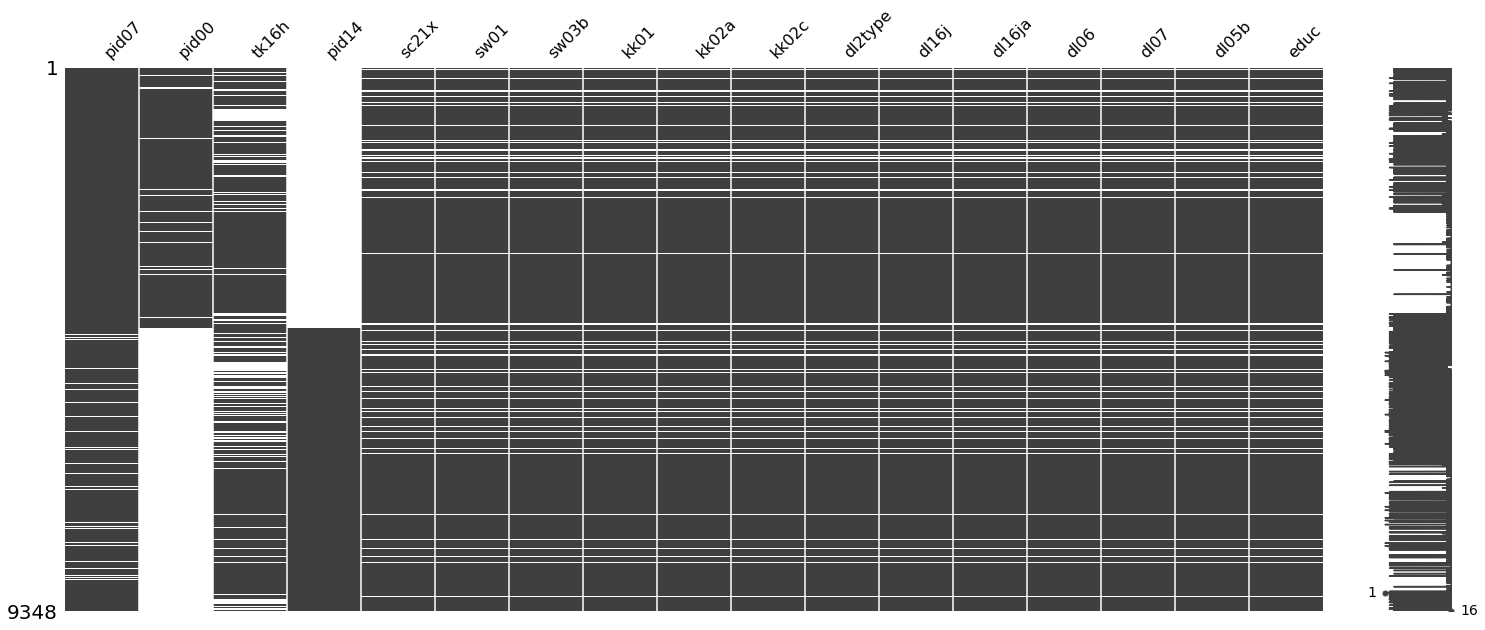

In [33]:
missingdata = data.columns[data.isnull().any()].tolist()
msno.matrix(data[missingdata]);

In [34]:
for i in data.columns:
    if data[i].isnull().sum() > 0:
        print (f"Percenage of missing data in {i} equal to", data[i].isnull().sum()/len(data))

Percenage of missing data in pid07 equal to 0.038510911424903725
Percenage of missing data in pid00 equal to 0.5483525887890458
Percenage of missing data in tk16h equal to 0.1735130509199829
Percenage of missing data in pid14 equal to 0.4797817715019255
Percenage of missing data in sc21x equal to 0.07317073170731707
Percenage of missing data in sw01 equal to 0.07317073170731707
Percenage of missing data in sw03b equal to 0.07317073170731707
Percenage of missing data in kk01 equal to 0.07317073170731707
Percenage of missing data in kk02a equal to 0.07381258023106547
Percenage of missing data in kk02c equal to 0.07317073170731707
Percenage of missing data in dl2type equal to 0.07317073170731707
Percenage of missing data in dl16j equal to 0.07413350449293966
Percenage of missing data in dl16ja equal to 0.0737056054771074
Percenage of missing data in dl06 equal to 0.07317073170731707
Percenage of missing data in dl07 equal to 0.07317073170731707
Percenage of missing data in dl05b equal to 

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [36]:
#create new a random forest model
random_forest = RandomForestClassifier(random_state=101 , 
                                      min_samples_split=25, min_samples_leaf=5,
                                      bootstrap=True, n_estimators=500)

param_grid = { 
    'bootstrap': [True],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [20, 25, 30, 35],
    'n_estimators': [300, 400, 500, 600]
}

#use gridsearch to test all values for n_neighbors
#randomf_gscv = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 6)

In [37]:
train_data = data.copy()

In [38]:
train_data.sw01.value_counts(dropna=False)

3.0    4860
2.0    1979
4.0    1079
1.0     746
NaN     684
Name: sw01, dtype: int64

## Categorical

In [39]:
%%time

#fit model to data
col_to_impute = ["sw01", "sw03b", "kk01", "kk02c", "educ", "dl07", "dl05b", "sc21x"]
for i in col_to_impute:
    df = train_data[train_data[i].notnull()]
    df1 = train_data[train_data[i].isnull()]
    list_independent = ["pce_t", "A_hr1type_t", "E_hr1type_t", "F_hr1type_t",  "age", "sex", "kabid", "married", "year"]
    X = df[list_independent] #independent variable to predict
    y = df[i]
    random_forest.fit(X, y)
    #predict
    X_test = df1[list_independent]
    df1[i] = random_forest.predict(X_test)
    train_data = pd.concat([df, df1])
    #X_r = dataset[list_independent]
    #y_r = dataset[i]
    random_forest.fit(X, y)
    y_arbit = random_forest.predict(X)
    print ("Score of model in ", i, "is", metrics.accuracy_score(y, y_arbit))

Score of model in  sw01 is 0.735803324099723
Score of model in  sw03b is 0.735803324099723
Score of model in  kk01 is 0.735803324099723
Score of model in  kk02c is 0.735803324099723
Score of model in  educ is 0.735803324099723
Score of model in  dl07 is 0.735803324099723
Score of model in  dl05b is 0.735803324099723
Score of model in  sc21x is 0.735803324099723
Wall time: 3min 58s


## Continuous

In [40]:
random_forest_1 = RandomForestClassifier(random_state=101 , 
                                      min_samples_split=25, min_samples_leaf=5,
                                      bootstrap=True, n_estimators=500)

col_to_impute = ["dl16j", "kk02a"]
for i in col_to_impute:
    df = train_data[train_data[i].notnull()]
    df1 = train_data[train_data[i].isnull()]
    list_independent = ["pce_t", "A_hr1type_t", "E_hr1type_t", "F_hr1type_t",  "age", "sex", "kabid", "married", "year"]
    X = df[list_independent] #independent variable to predict
    y = df[i]
    random_forest_1.fit(X, y)
    #predict
    X_test = df1[list_independent]
    df1[i] = np.round(random_forest_1.predict(X_test))
    train_data = pd.concat([df, df1])
    print ("Score of model in ", i, "is", random_forest_1.score(X, y))

Score of model in  dl16j is 0.5548238012709417
Score of model in  kk02a is 0.6395241395241396


In [41]:
for i in train_data.columns:
    if train_data[i].isnull().sum() > 0:
        print (f"Percenage of missing data in {i} equal to", train_data[i].isnull().sum()/len(train_data))

Percenage of missing data in pid07 equal to 0.038510911424903725
Percenage of missing data in pid00 equal to 0.5483525887890458
Percenage of missing data in tk16h equal to 0.1735130509199829
Percenage of missing data in pid14 equal to 0.4797817715019255
Percenage of missing data in dl2type equal to 0.07317073170731707
Percenage of missing data in dl16ja equal to 0.0737056054771074
Percenage of missing data in dl06 equal to 0.07317073170731707


|variable|description|
|---|---|
tk01| main acivity
dl06| highest education attainment
dl05a| first age entered elementary school
dl11d| gratuated?
dl11f| year of graduated OR dropout
dl16c2| number of subjects in the EBTANAS / UAN / UN exam
sw00| overall subjective welfare right now
sw01| subjective economic status
sw03b| subjective household condition
kk01| subjective overall health condition
kk02a| days missed at primary activity last month
kk02c| Compared health 12 months ago
ar02b| relation with Head Household
sc21x| migration history

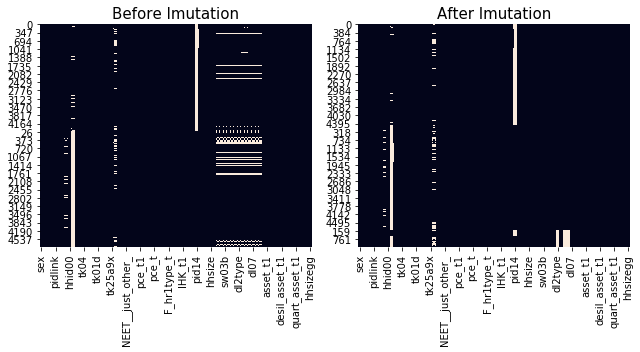

In [42]:
plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
sns.heatmap(data.isnull(), cbar=False)
plt.title("Before Imutation", size=15)
plt.subplot(1,2,2)
sns.heatmap(train_data.isnull(), cbar=False)
plt.title("After Imutation", size=15)
plt.tight_layout()

In [43]:
train_data.to_stata("data_thesis_redi.dta")